$$ \LaTeX \text{ command declarations here.}
\newcommand{\R}{\mathbb{R}}
\renewcommand{\vec}[1]{\mathbf{#1}}
\newcommand{\X}{\mathcal{X}}
\newcommand{\D}{\mathcal{D}}
\newcommand{\G}{\mathcal{G}}
\newcommand{\L}{\mathcal{L}}
\newcommand{\X}{\mathcal{X}}
\newcommand{\Parents}{\mathrm{Parents}}
\newcommand{\NonDesc}{\mathrm{NonDesc}}
\newcommand{\I}{\mathcal{I}}
\newcommand{\dsep}{\text{d-sep}}
\newcommand{\Cat}{\mathrm{Categorical}}
\newcommand{\Bin}{\mathrm{Binomial}}
$$

In [6]:
from __future__ import division

# plotting
%matplotlib inline
from matplotlib import pyplot as plt;
import matplotlib as mpl;
from mpl_toolkits.mplot3d import Axes3D

# scientific
import numpy as np;
import sklearn as skl;
import sklearn.datasets;
import sklearn.cluster;
import sklearn.mixture;

# ipython
import IPython;

# python
import os;
import random;

#####################################################

# image processing
import PIL;

# trim and scale images
def trim(im, percent=100):
    print("trim:", percent);
    bg = PIL.Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = PIL.ImageChops.difference(im, bg)
    diff = PIL.ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        x = im.crop(bbox)
        return x.resize(((x.size[0]*percent)//100, 
                         (x.size[1]*percent)//100), 
                        PIL.Image.ANTIALIAS);


#####################################################

# daft (rendering PGMs)
import daft;

# set to FALSE to load PGMs from static images
RENDER_PGMS = True;

# decorator for pgm rendering
def pgm_render(pgm_func):
    def render_func(path, percent=100, render=None, *args, **kwargs):
        print("render_func:", percent);
        # render
        render = render if (render is not None) else RENDER_PGMS;
        
        if render:
            print("rendering");
            # render
            pgm = pgm_func(*args, **kwargs);
            pgm.render();
            pgm.figure.savefig(path, dpi=300);
            
            # trim
            img = trim(PIL.Image.open(path), percent);
            img.save(path, 'PNG');
        else:
            print("not rendering");
        
        # error
        if not os.path.isfile(path):
            raise Exception("Error:  Graphical model image %s not found.  \
            You may need to set RENDER_PGMS=True." % path);
        
        # display
        return IPython.display.Image(filename=path);
    return render_func;

######################################################

# EECS 545:  Machine Learning

## Lecture 19:  Unsupervised Learning (PCA & ICA)

- Instructor:  **Jacob Abernethy**
- Date:  March 28, 2016

*Lecture Exposition:*  Saket

## References

- **[MLAPP]** Murphy, Kevin. [*Machine Learning:  A Probabilistic Perspective*](https://mitpress.mit.edu/books/machine-learning-0).  2012.
- **[PRML]** Bishop, Christopher.  [*Pattern Recognition and Machine Learning*](http://research.microsoft.com/en-us/um/people/cmbishop/prml/).  2006.

## Outline

- Probabilistic Components Analysis
    - Classical View
    - Probabilistic PCA
- Independent Components Analysis
    - Cocktail Party Problem

# Principal Components Analysis

> Uses material from **[MLAPP]** and **[PRML]**

### Dimensionality Reduction

High-dimensional data may have **low-dimensional structure**.
- We only need two dimensions to describe a rotated plane in 3d!

In [34]:
def plot_plane():
    # random samples
    n = 200;
    data = np.random.random((3,n));
    data[2,:] = 0.4 * data[1,:] + 0.6 * data[0,:];
    
    # plot plane
    fig = plt.figure(figsize=(10,6));
    ax = fig.add_subplot(111, projection="3d");
    ax.scatter(*data);

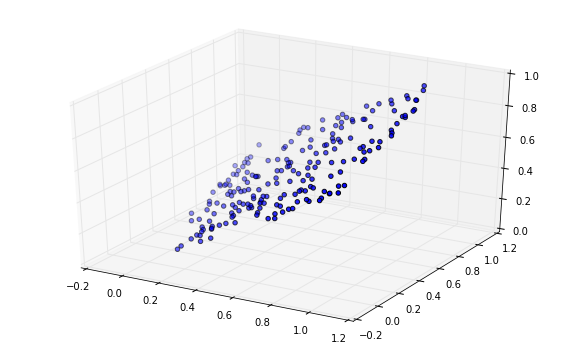

In [36]:
plot_plane()

### Dimensionality Reduction

Data may even be embedded in a low-dimensional **nonlinear manifold**.
- How can we recover a low-dimensional representation?

<img src="images/swiss-roll.png">

### Dimensionality Reduction

As an even more extreme example, consider a dataset consisting of the same image translated and rotate in different directions:
- Only 3 degrees of freedom for a 100x100-dimensional dataset!

<img src="images/pca_1.png" align="middle">

### Principal Components Analysis

Given a set $X = \{x_n\}$ of observations 
* in a space of dimension $D$, 
* find a **linear subspace** of dimension $M < D$ 
* that captures most of its variability.

PCA can be described in two equivalent ways:
* maximizing the variance of the projection, or
* minimizing the squared approximation error.

### PCA:  Equivalent Descriptions

Maximize variance or minimize squared projection error:
    
<img src="images/pca_2.png" height = "300px" width = "300px"  align="middle">

### PCA:  Equivalent Descriptions

With mean at the origin $ c_i^2 = a_i^2 + b_i^2 $, with constant $c_i^2$

* Minimizing $b_i^2$ maximizes $a_i^2$ and vice versa

<img src="images/pca_3.png" height = "300px" width = "300px"  align="middle">

### PCA:  First Principal Component

Given data points $\{x_n\}$ in $D$-dim space.
* Mean $\bar x = \frac{1}{N} \sum_{n=1}^{N} x_n $
* Data covariance ($D \times D$ matrix): 
     $ S = \frac{1}{N} \sum_{n=1}^{N}(x_n - \bar x)(x_n - \bar x)^T$

Let $u_1$ be the **principal component** we want.
* Unit length $u_1^T u_1 = 1$
* Projection of $x_n$ is $u_1^T x_n$

### PCA:  First Principal Component

**Goal:** Maximize the projection variance:
    $$ \frac{1}{N} \sum_{n=1}^{N}\{u_1^Tx_n - u_1^T \bar x \}^2 = u_1^TSu_1$$

* Use a Lagrange multiplier to enforce $u_1^T u_1 = 1$
     - Maximize: $u_1^T S u_1 + \lambda(1-u_1^T u_1)$

* Derivative is zero when $ Su_1 = \lambda u_1$
    * That is, $u_1^T S u_1 = \lambda $

* So $u_1$ is eigenvector of $S$ with largest eigenvalue.

### PCA:  Maximizing Variance

The top $M$ eigenvectors of the empirical covariance matrix $S$ give the $M$ principal components of the data.
- Minimizes squared projection error
- Maximizes projection variances

**Recall:** These are the top $M$ left singular vectors of the data matrix $X$.
- c.f. Homework 1

### Example:  Eigenfaces

<img src="images/pca_9.png"  align="middle">

### Example:  Face Recognition via Eigenfaces

In [39]:
## scikit example: Faces recognition example using eigenfaces and SVMs

from __future__ import print_function

from time import time
import matplotlib.pyplot as plt

from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC


###############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]


###############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)


###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

#print("Extracting the top %d eigenfaces from %d faces"
#      % (n_components, X_train.shape[0]))
#t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
#print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

#print("Projecting the input data on the eigenfaces orthonormal basis")
#t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
#print("done in %0.3fs" % (time() - t0))


###############################################################################
# Train a SVM classification model

#print("Fitting the classifier to the training set")
#t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
#print("done in %0.3fs" % (time() - t0))
#print("Best estimator found by grid search:")
#print(clf.best_estimator_)


###############################################################################
# Quantitative evaluation of the model quality on the test set

#print("Predicting people's names on the test set")
#t0 = time()
y_pred = clf.predict(X_test_pca)
#print("done in %0.3fs" % (time() - t0))

#print(classification_report(y_test, y_pred, target_names=target_names))
#print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


###############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]



/home/ben/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/func_inspect.py:191: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  arg_spec = inspect.getargspec(func)


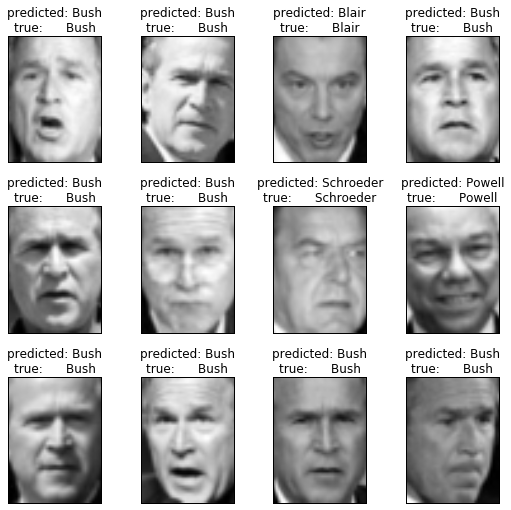

In [40]:
plot_gallery(X_test, prediction_titles, h, w)

### Example:  Face Recognition

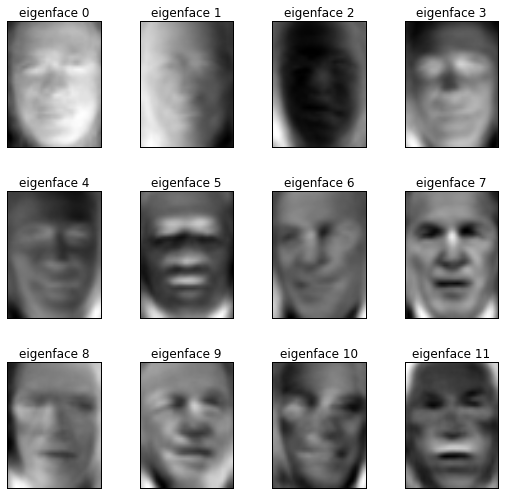

In [42]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

### Probabilistic PCA

We can view PCA as solving a probabilistic **latent variable** problem.
    $$
    \begin{align}
    x &= Wz + \mu + \epsilon \\
    z &\sim \mathcal{N}(0, I_M)
    \end{align}
    $$
where we describe 
- data $x \in \R^D$ in terms of
- latent variable $z \in \R^M$ in lower dimensional space, via
- linear transformation $W \in \R^{D \times M}$ maps $x \mapsto z$

### Probabilistic PCA

Given the generative model
$$ x  = Wz + \mu + \epsilon $$

we can infer

$$ \mathbb{E}[x]  = \mathbb{E}[Wz + \mu + \epsilon] = \mu $$

$$ \begin {align}
cov[x]  
&= \mathbb{E}[(Wz + \epsilon)(Wz + \epsilon)^T] \\
&= \mathbb{E}[(Wzz^TW^T] + \mathbb{E}[ \epsilon \epsilon^T] \\
&= WW^T + \sigma^2 I
\end{align}
$$

### Probabilistic PCA

$$ x  = Wz + \mu + \epsilon $$

<img src="images/pca_7.png" height = "600px" width = "600px"  align="middle">


### Probabilistic PCA:  Likelihood

* (Marginal) likelihood
$$ \begin{align}
\log p(X|\mu, W, \sigma^2)
&= \sum_n p(x_n| W, \mu, \sigma^2) \\
&= -\frac{ND}{2} \log 2\pi - \frac{N}{2} \log |C| -\frac{1}{2} \sum_n (x_n - \mu)^TC^{-1}(x_n - \mu) \\
C = WW^T + \sigma^2 I 
\end{align}
$$


* We can simply maximize this likelihood function with respect to $\mu, W, \sigma$.

### Probabilistic PCA:  Maximum Likelihood

* Mean: $\mu = \bar x$ 

* Noise: $ \sigma_{ML}^2 = \frac{1}{D-M} \sum_{i=M+1} ^{D} \lambda_i $

* W: $W_{ML} = U_M (L_M - \sigma^2 I)^{\frac{1}{2}} R $

where $L_M$ is diag with the $M$ largest eigenvalues
and $U_M$ is the $M$ corresponding eigenvectors
And $R$ is an arbitrary $M\times M$ rotation (i.e., $z$ can be defined by rotating “back”)

### Probabilistic PCA:  Expectation Maximization

* Latent variable model

$$ p(z) = \mathcal {N}(z|0, I) $$
$$ p(x|z) = \mathcal{N}(x|Wz + \mu, \sigma^2 I) $$


* E-step: Estimate the posterior $Q(z)=P(z|x)$ 
    * Use linear Gaussian


* M-step: Maximize the data-completion likelihood given $Q(z)$:
$$ \underset{\theta = \{\mu, W, \sigma\}}{\\max}\hspace{1em}  \sum_i \sum_{z^{(i)}} Q(z^{(i)}) log P_\theta (x^{(i)}, z^{(i)}) $$ 

#### PPCA:  Advantages of EM over SVD

* EM can be **faster**. In particular, assuming $N$, $D \gg L$, the dominant cost of EM is the projection operation in the E step, so the overall time is $O(T L N D)$, where $T$ is the number of iterations.

* EM can be implemented in an **online** fashion, i.e., we can update our estimate of $W$ as the data streams in.

* EM can handle **missing data** in a simple way.

* EM can be extended to handle **mixtures of PPCA/ FA models**.

* EM can be modified to **variational EM** or to variational Bayes EM to fit more complex models.

### Probabilistic PCA:  Expectation Maximization

<img src="images/pca_8.png"  align="middle">

### Kernel PCA

Suppose the regularity that allows dimensionality reduction is non-linear.

<img src="images/pca_4.png" style="float:left; width:40%"> 
<img src="images/pca_5.png" style="float:right; width:40%">

### Kernel PCA

* As with regression and classification, we can transform the raw input data {xn} to a set of feature values

$$ \{x_n\} \rightarrow \{\phi(x_n)\} $$


* Linear PCA (on the nonlinear feature space) gives us a linear subspace in the feature value space, corresponding to nonlinear structure in the data space.

### Kernel PCA

* Define a kernel, to avoid having to evaluate the feature vectors explicitly.
$$ \kappa (x, x') = \phi(x)^T \phi(x') $$


* Define the Gram matrix K of pairwise similarities among the data points:
$$ K_{nm} = \phi (x_n)^T \phi(x_m) = \kappa (x_n, x_m) $$


* Express PCA in terms of the kernel,
    * Some care is required to centralize the data.

# Independent Components Analysis

> Uses material from **[MLAPP]** and **[PRML]**

### Independent Component Analysis

Suppose N independent signals are mixed, and sensed by N independent sensors.
* Cocktail party with speakers and microphones.
* EEG with brain wave sources and sensors.

> Can we reconstruct the original signals, given the mixed data from the sensors?

### Independent Component Analysis

The sourcess must be independent.
* And they **must be non-Gaussian**.
* If Gaussian, then there is no way to find unique independent components.

Linear mixing to get the sensor signals x.
* $x = As$
* or $s = Wx$ (i.e., $W = A^{-1}$ )
    
$A$ are the **bases**, $W$ are the **filters**

### ICA:  Algorithm

* There are several formulations of ICA:
    * Maximum likelihood
    * Maximizing non-Gaussianity (popular)
    

* Common steps of ICA (e.g., FastICA):
    * Apply PCA whitening (aka sphering) to the data
    * Find orthogonal unit vectors along which the that non-Gaussianity are maximized
    $$ \underset{W}{\\max}\hspace{1em} f(W \tilde x) \hspace{2em} s.t.\hspace{1em} WW^T = I$$
    where f(x) can be “kurtosis”, L1 norm, etc.

### ICA:  Step 1, Preprocessing

We use **PCA Whitening** to preprocess the data:
    * Apply PCA: $ \Sigma = U \Lambda U^T $ 
    * Project (rotate) to the principal components
    * “Scale” each axis so that the transformed data has identity as covariance.

<img src="images/pca.jpg" align="middle">

### ICA:  Step 2, Maximize Non-Gaussianity

Rotate to maximize non-Gaussianity

<img src="images/ica_1.png" align="middle">
$\hspace{6em}x \hspace{8em} x_{PCA} = U^Tx \hspace{6em} x_{PCA} = \Lambda^{-\frac{1}{2}} U^Tx \hspace{6em} x_{ICA} = V \Lambda^{-\frac{1}{2}} U^Tx$ 

### ICA vs PCA

In [46]:
from __future__ import division
import numpy as np
from sklearn.decomposition import FastICA
from matplotlib import pyplot as plt
import seaborn;

# thanks to Daniel LeJeune for the code!
def plot_ica_pca():

    # original samples
    S = np.random.rand(2,500)
    plt.subplot(2,2,1)
    plt.scatter(S[0,:], S[1,:])
    plt.title('Original')

    # observed samples
    A = np.array([[1, 2], [-2, 1]])
    X = A.dot(S)
    plt.subplot(2,2,2)
    plt.scatter(X[0,:], X[1,:])
    plt.title('Mixed (observed)')

    # PCA recovered samples
    _,_,V = np.linalg.svd(X)
    plt.subplot(2,2,3)
    plt.scatter(V[0,:], V[1,:])
    plt.title('PCA')

    # ICA recovered samples
    fica = FastICA()
    Y = fica.fit_transform(X.T).T
    plt.subplot(2,2,4)
    plt.scatter(Y[0,:], Y[1,:])
    plt.title('ICA')

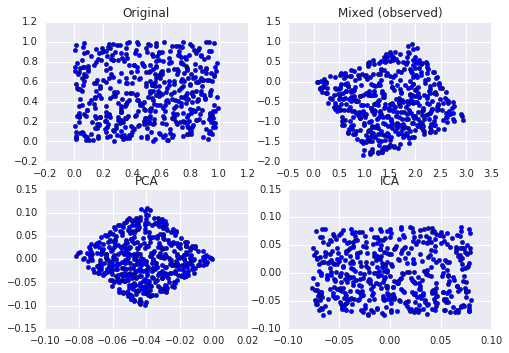

In [47]:
plot_ica_pca()

### ICA:  Mixture Example

Input Signals and Density
<img src="images/ica_mix.png" align="middle">

### ICA:  Mixture Example

To whiten the input data:

* We want a linear transformation $ y = V x $

* So the components are uncorrelated: $\mathbb{E}[yy^T] = I $

* Given the original covariance $ C = \mathbb{E}[xx^T]$

* We can use $V = C^{-\frac {1}{2}} $

* Because $ \mathbb{E}[yy^T] = \mathbb{E}[Vxx^TV^T] = C^{-\frac {1}{2}} C C^{-\frac {1}{2}} = I $  

### ICA:  Mixture Example


<img src="images/ica_3.png" align="middle">

### ICA:  Mixture Example

<img src="images/ica_4.png" align="middle">

### ICA:  Mixture Example

<img src="images/ica_5.png" align="middle">

### ICA:  Mixture Example

<img src="images/ica_6.png" align="middle">

### ICA:  Mixture Example

<img src="images/ica_7.png" align="middle">

### ICA:  Summary

* Learning can be done by PCA whitening followed kurtosis maximization.
* ICA is widely used for **blind-source separation**
* The ICA components can be used for features.
* Limitation: difficult to learn overcomplete bases due to the orthogonality constraint